In [1]:
import numpy as np
import pandas as pd

In [2]:
class Sym_matrix:
    def __init__(self, m):
        self.m = m
        self._data = np.zeros(shape=(m, m))

    def __getitem__(self, inds):
        i, j = inds
        if i > j:
            i, j = j, i
        return self._data[i][j]
    
    def __setitem__(self, inds, val):
        i, j = inds
        if i == j:
            raise Exception('Cannot change value')
        if i > j:
            i, j = j, i
        self._data[i][j] = val
    def __str__(self):
        return str(self._data + self._data.T)


In [3]:
affinty_mat = Sym_matrix(5)
print(affinty_mat)
affinty_mat[2, 1] = 5
print(affinty_mat)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0.]
 [0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
import requests
zip_url = 'https://cloud.vinhthanh.net/s/3tHa4poANfk6a4F/download/congress_votes_104-1995.zip'
zesp = requests.get(zip_url)
zip_bin = zesp.content

In [5]:
import zipfile
from io import BytesIO
vote_df = None
with zipfile.ZipFile(BytesIO(zip_bin), 'r') as zip_f:
    for entry in zip_f.namelist():
        with zip_f.open(entry) as f:
            content = f.read()
            #print(content)
            first_newline = content.index(b'\n')
            content = content[first_newline + 1:]
            df = pd.read_csv(BytesIO(content))[['person', 'vote']]
            role = entry.split('_')[-1].replace('.csv','')
            df['role'] = role
            if vote_df is None:
                vote_df = df
            else:
                vote_df = pd.concat([vote_df, df], copy=False)
            #break
print(vote_df.shape)
print(vote_df.head())
vote_df.reset_index(inplace=True)
print(vote_df.loc[0])
print(vote_df['vote'].unique())



(5476, 3)
   person vote  role
0  300001  Nay  s220
1  300005  Yea  s220
2  300007  Yea  s220
3  300008  Nay  s220
4  300009  Nay  s220
index          0
person    300001
vote         Nay
role        s220
Name: 0, dtype: object
['Nay' 'Yea' 'Not Voting' 'Present']


In [6]:
filter = (vote_df['vote'] == 'Nay') | (vote_df['vote'] == 'Yea')
vote_df = vote_df[filter]
vote_df.reset_index(inplace=True)
print(vote_df.shape)

(5317, 5)


In [7]:
import yaml
legis_url = 'https://cloud.vinhthanh.net/s/5kLWX7QBpf374Yz/download/legislators-historical.yaml'
resp = requests.get(legis_url)
legis = yaml.safe_load(resp.content)

In [8]:
print(legis[0])

{'id': {'bioguide': 'B000226', 'govtrack': 401222, 'icpsr': 507, 'wikipedia': 'Richard Bassett (Delaware politician)', 'wikidata': 'Q518823', 'google_entity_id': 'kg:/m/02pz46'}, 'name': {'first': 'Richard', 'last': 'Bassett'}, 'bio': {'birthday': '1745-04-02', 'gender': 'M'}, 'terms': [{'type': 'sen', 'start': '1789-03-04', 'end': '1793-03-03', 'state': 'DE', 'class': 2, 'party': 'Anti-Administration'}]}


In [9]:
rows = []
for person in legis:
    person_name = person['name']['first'] + '' + person['name']['last']
    party = None
    if 'party' in person['terms'][-1]:
        party = person['terms'][-1]['party']
    
    row = [person['id']['govtrack'], person_name, party]
    rows.append(row)
legis_df = pd.DataFrame(columns=['id' , 'name', 'party'], data = rows)

print(legis_df.shape)
print(legis_df.head(5))

(12136, 3)
       id             name                party
0  401222   RichardBassett  Anti-Administration
1  401521  TheodorickBland                 None
2  402032     AedanusBurke                 None
3  402334    DanielCarroll                 None
4  402671     GeorgeClymer                 None


In [10]:
filter = (legis_df['party']=='Democrat') | (legis_df['party'] == 'Republican')
legis_df = legis_df[filter]
legis_df.reset_index(inplace=True)
print(legis_df)

       index      id               name       party
0         32  402077          AaronBurr  Republican
1         79  407188    AlexanderMartin  Republican
2        100  410689      HenryTazewell  Republican
3        104  401537  TimothyBloodworth  Republican
4        107  402753         IsaacColes  Republican
...      ...     ...                ...         ...
10036  12131  456866       ConnieConway  Republican
10037  12132  456867        MayraFlores  Republican
10038  12133  456872  JosephSempolinski  Republican
10039  12134  300055        JamesInhofe  Republican
10040  12135  412671      BenjaminSasse  Republican

[10041 rows x 4 columns]


In [11]:
def activator(votes_A, votes_B):
    same_vote_qt = 0
    rote_qt = 0

    for _, vote_A in votes_A.iterrows():
        for _, vote_B in votes_B.iterrows():
            if vote_A['role'] == vote_B['role']:
                rote_qt += 1
                if vote_A['vote'] == vote_B['vote']:
                    same_vote_qt += 1
                break
    return same_vote_qt / rote_qt if rote_qt != 0 else 0

In [12]:
m = legis_df.shape[0]
affinty_mat = Sym_matrix(m)

cache = {}

def get_votes(voter_id):
    if voter_id not in cache:
        cache[voter_id] = vote_df[vote_df['person'] == voter_id]
    return cache[voter_id]

for i in range(0, m-1):
    voter_A = legis_df.loc[i]
    votes_A = get_votes(voter_A['id'])
    if votes_A.empty: continue

    for j in range(i+1, m):
        voter_B = legis_df.loc[j]
        votes_B = get_votes(voter_B['id'])
        if votes_B.empty: continue

        affinty_mat[i, j] = activator(votes_A, votes_B)


In [13]:
found_res = False
for i in range(0, m-1):
    for j in range(i +1, m):
        if affinty_mat[i, j] != 0:
            print(f'{i}, {j}')
            found_res = True
            break
    if found_res : break

8787, 8789


In [14]:
print(affinty_mat[8787, 8789])

0.34


In [19]:
class Edge:
    def __init__(self, node1, node2):
        self.id = node1.id = node2.id
        self.node1 = node1
        self.node2 = node2

    def __hash__(self):
        return hash(self.id)
    
    def __eq__(self, other):
        return self.__class__ == other.__class__ and\
            self.id == other.id

In [16]:
class Graph_node:
    def __init__(self, id, name):
        self.name = name
        self.id = id
        self.nodes = {}

    def add_nodes(self, nodes):
        for node in nodes:
            edge = Edge(self, node)
            self.nodes[edge] = node

    def __hash__(self):
        return hash(self.id)
    
    def __eq__(self, other):
        return self.__class__ == other.__class__ and\
            self.id == other.id

In [23]:
import networkx as nx 
import matplotlib.pyplot as plt 

class Network_graph:
    def __init__(self, nodes):
        self.nodes = nodes

    def draw_networkx(self):
        g = nx.Graph()

        for node in self.nodes:
            for edge in node.nodes:
                node1_label = edge.node1.name
                node2_label = edge.node2.name
                g.add_edge(node1_label, node2_label)

        _, ax = plt.subplots(figsize=(30, 30))
        pos = nx.kamada_kawai_layout(g)
        nx.draw_networkx(g, pos, node_size=1000, font_size=14, node_color='white', 
            edge_color='grey', ax=ax)
        return pos


{'A': array([ 6.05371315e-03, -2.14355128e-05]),
 'B': array([-0.00292803,  1.        ]),
 'C': array([-0.00312569, -0.99997856])}

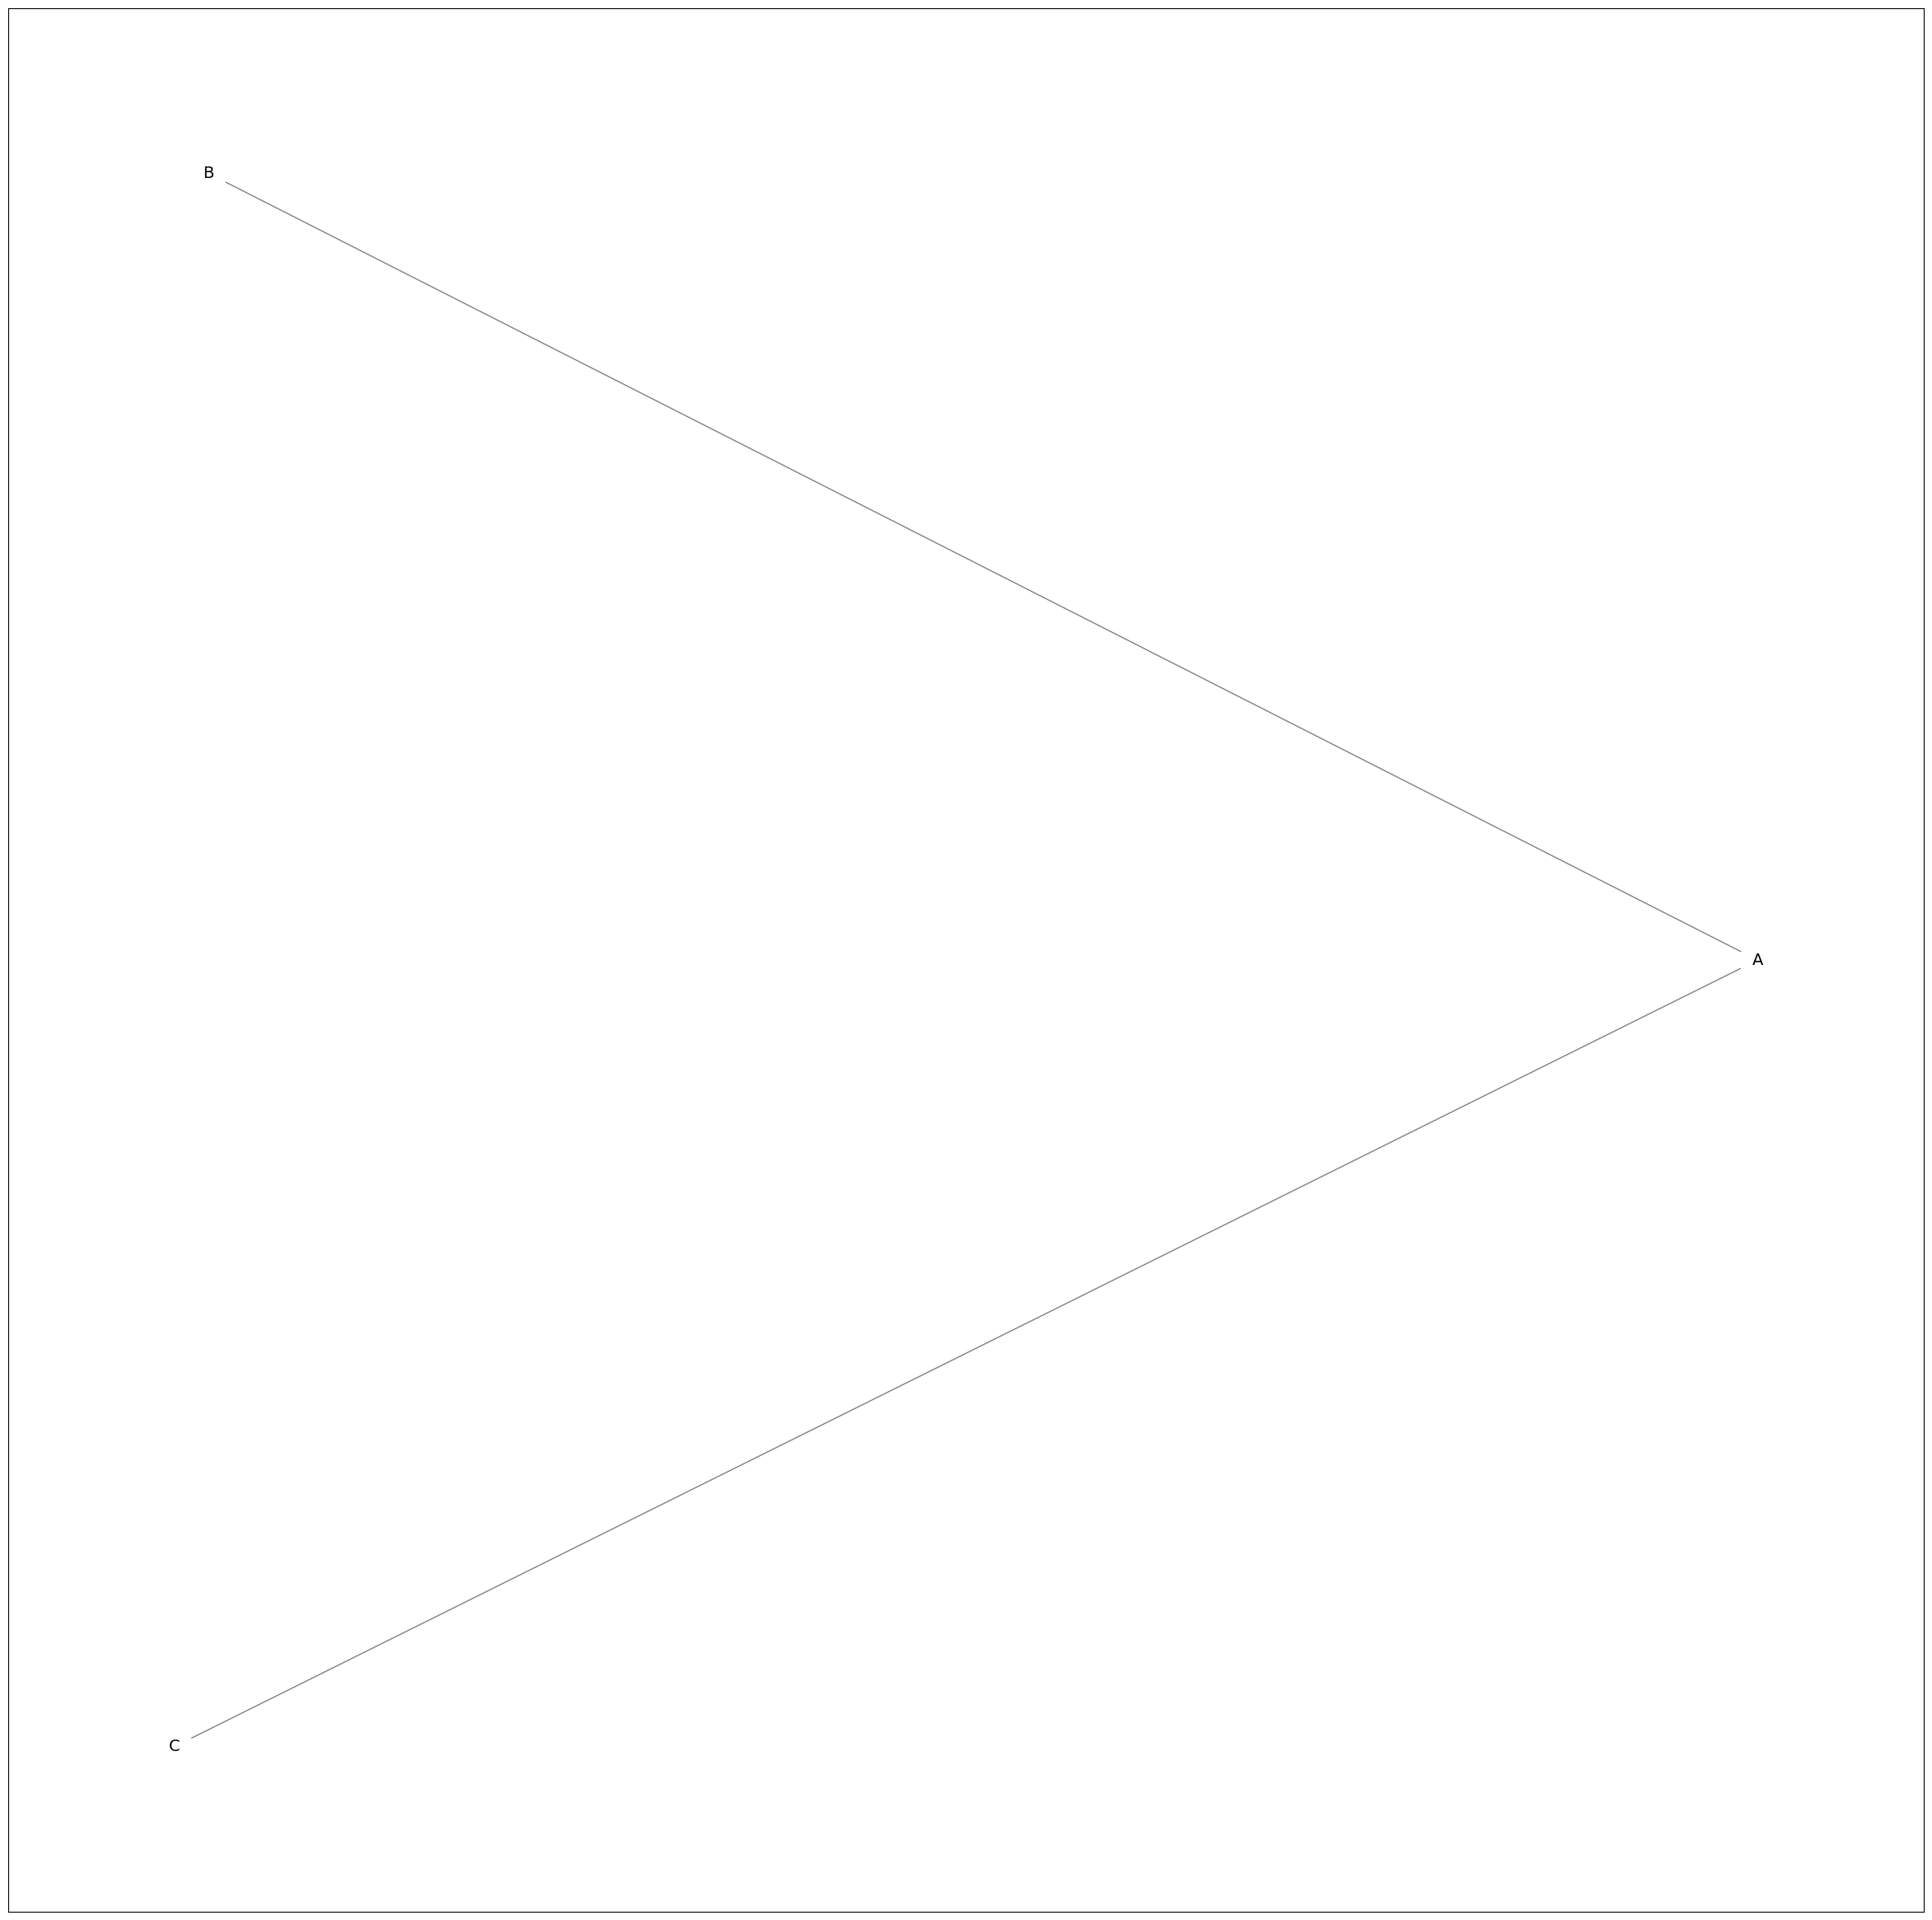

In [24]:
node_A = Graph_node(1, 'A')
node_B = Graph_node(2, 'B')
node_C = Graph_node(3, 'C')
node_A.add_nodes([node_B, node_C])
graph = Network_graph([node_A, node_B, node_C])
graph.draw_networkx()

In [41]:
found_res = False
nodes = []

for i in  range (m):
    for j in range (i +1 , m ):
        if affinty_mat [i,j] > 0.65:
            userA  = Graph_node(i , legis_df.loc[i] ["name"])
            userB  = Graph_node(j , legis_df.loc[j] ["name"])
            userA.add_nodes([userB])
            nodes.extend([userA,userB])

{'WilliamBradley': array([0.15230639, 0.87541973]),
 'J.Exon': array([0.22011469, 0.17698972]),
 'SamuelNunn': array([0.42040888, 0.20126658]),
 'ClaibornePell': array([0.49570345, 0.95104319]),
 'DavidPryor': array([0.55503805, 0.38775941]),
 'PaulSimon': array([0.36855887, 0.998194  ]),
 'DaleBumpers': array([0.68943013, 0.48954464]),
 'WendellFord': array([0.31650115, 0.1724848 ]),
 'JohnGlenn': array([0.35875099, 0.37109712]),
 'CarolMoseley Braun': array([0.03883458, 0.88477243]),
 'RichardBryan': array([0.49011989, 0.44911356]),
 'J.Kerrey': array([-0.01416621,  0.45971195]),
 'DanielMoynihan': array([0.67847458, 0.37368997]),
 'CharlesRobb': array([0.05405122, 0.34838848]),
 'PaulWellstone': array([0.69154968, 0.58982226]),
 'ThomasDaschle': array([0.39939347, 0.53505809]),
 'BobGraham': array([0.25798537, 0.33413859]),
 'PaulSarbanes': array([0.21458487, 0.62068973]),
 'ChristopherDodd': array([0.33480225, 0.6660982 ]),
 'ByronDorgan': array([0.67300608, 0.67056949]),
 'Russell

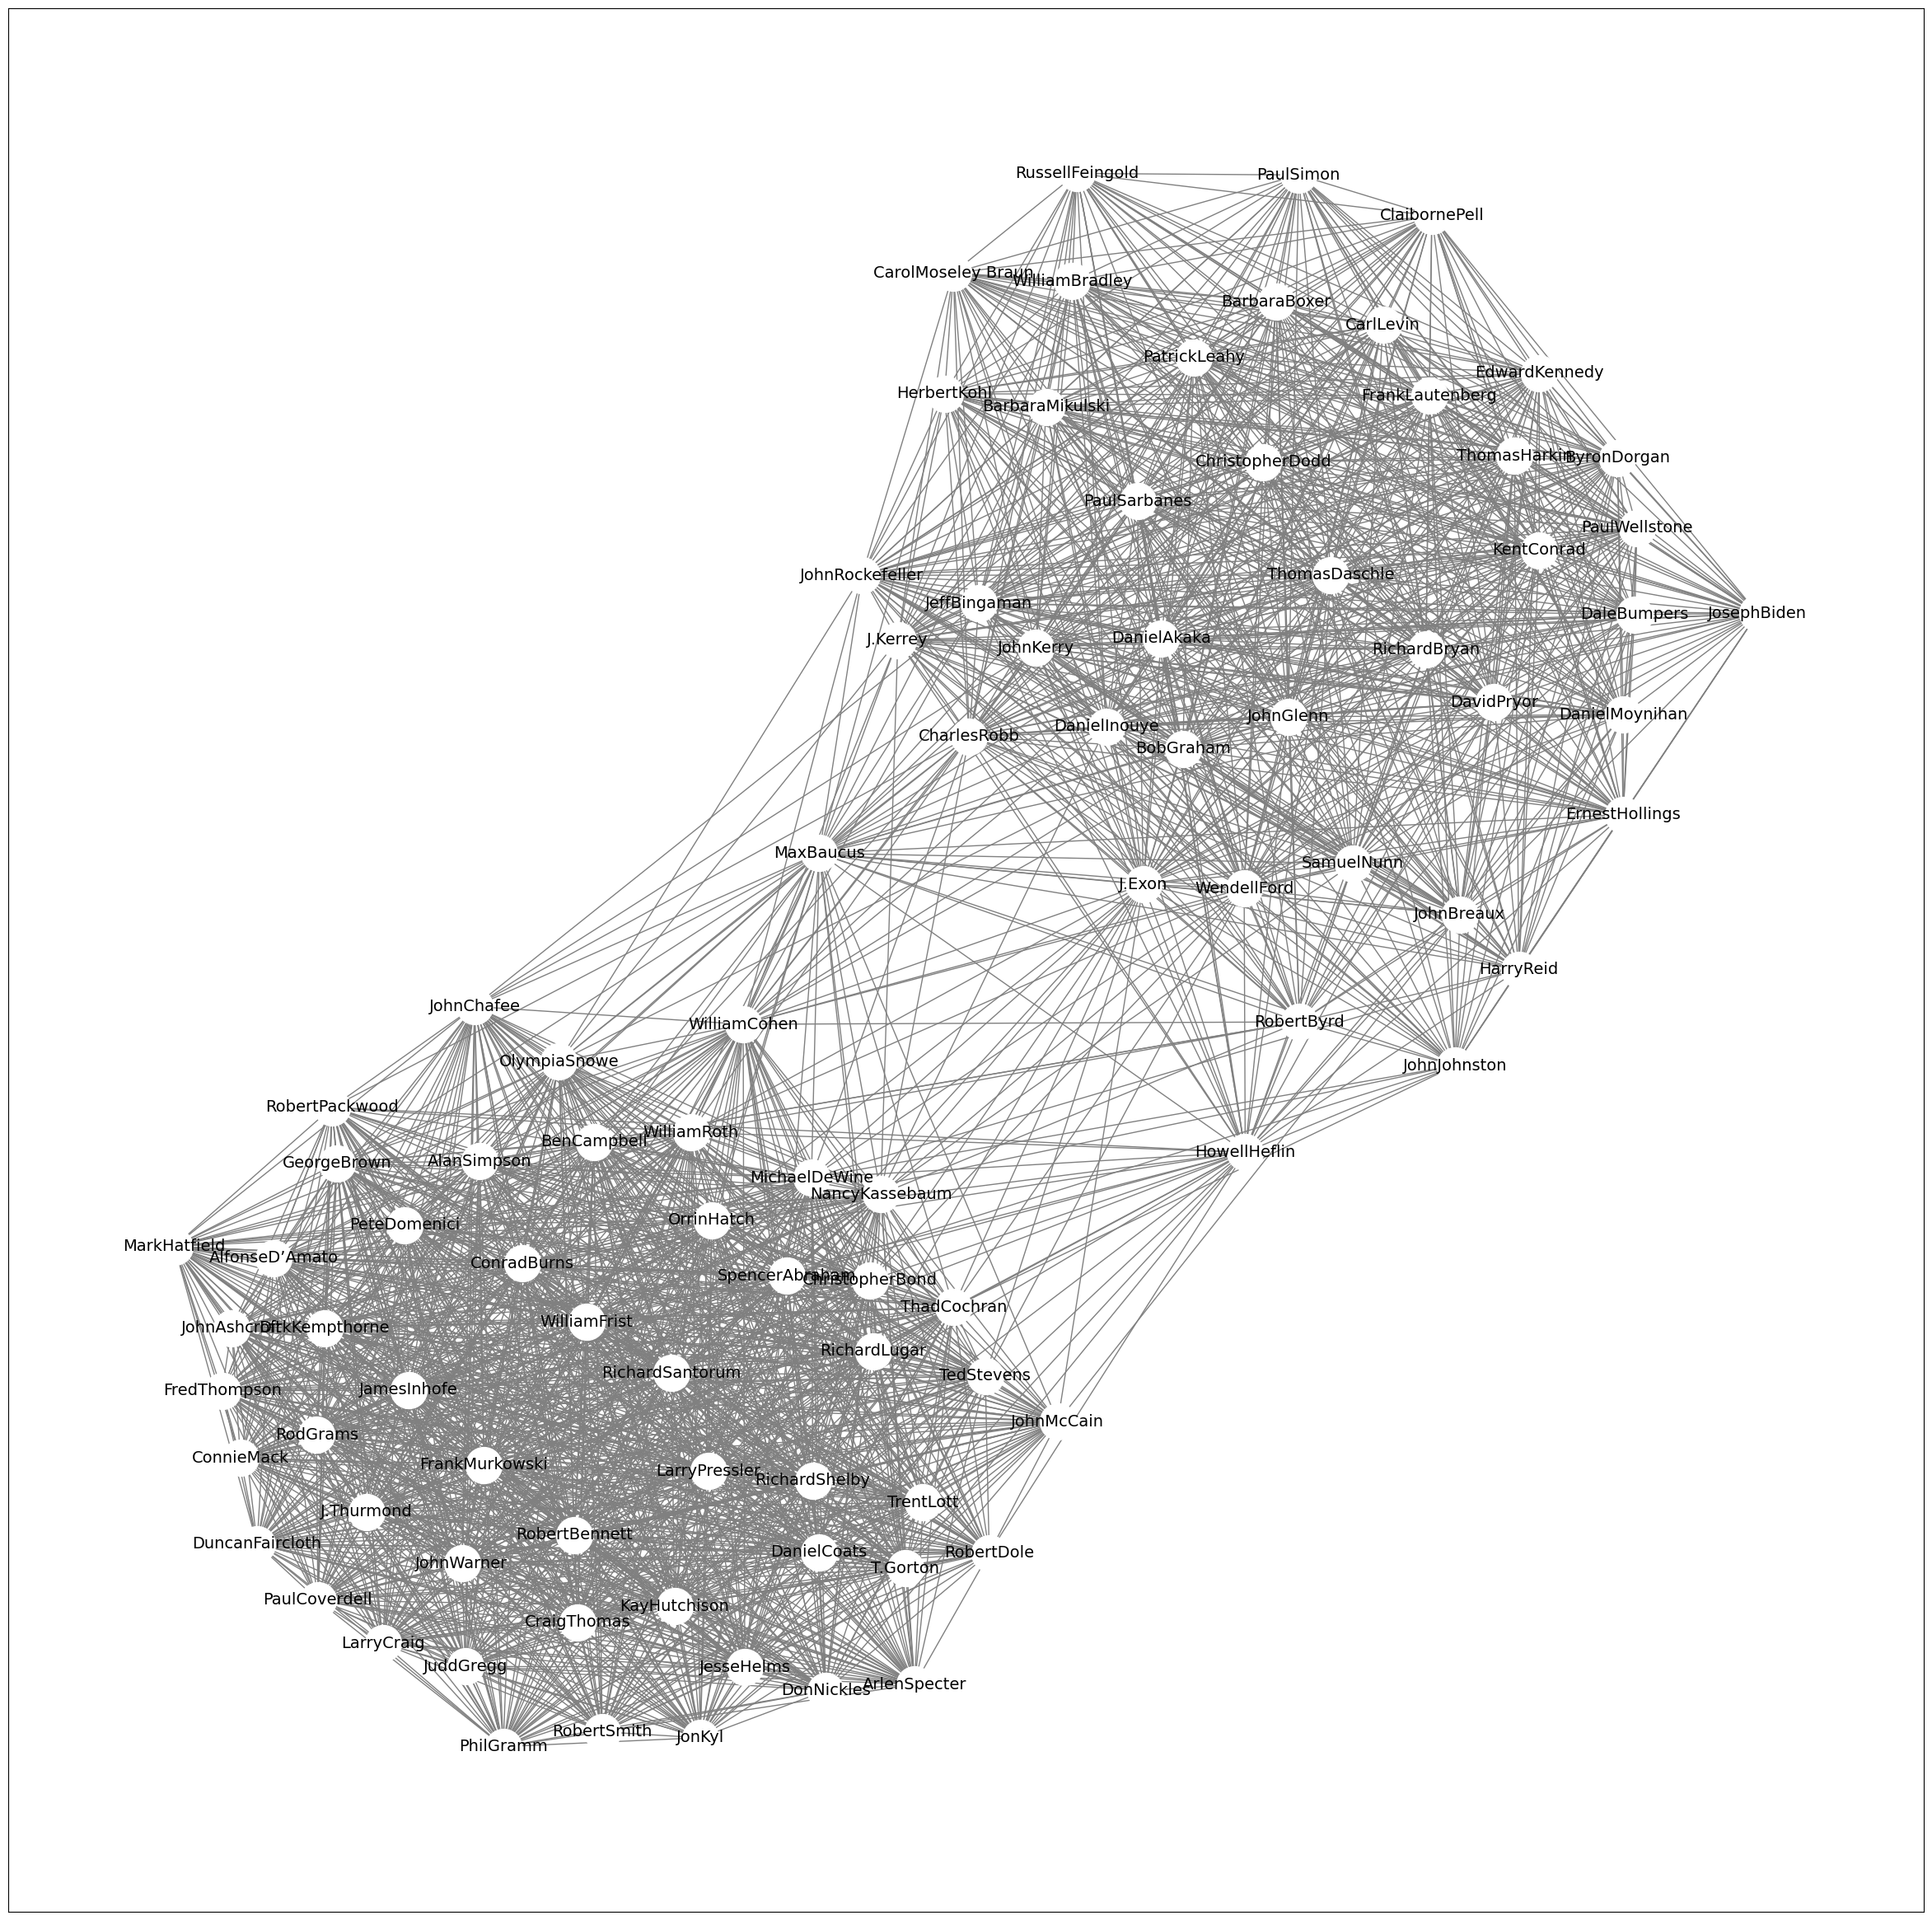

In [42]:
graph= Network_graph(nodes)
graph.draw_networkx()